# Classificazione signer con XGBoost

## Import delle librerie

In [2]:
import itertools
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

from handcrafted.app.dataset.dataset_loader import DatasetLoader
from handcrafted.app.dataset.utils.dataset_creator import DatasetCreator
from handcrafted.app.dataset.utils.frames_splitter import FramesSplitter
from handcrafted.app.model.model_statistics import ModelStatistics

## Caricamento del dataset
La classe [DatasetLoader](./handcrafted/app/dataset/dataset_loader.py) permette di caricare l'intero dataset direttamente da disco.
Questo è possibile in quanto basa il caricamento sulla struttura dei file e delle cartelle.

In [3]:
loader = DatasetLoader(directory="./data/frames_no_bg/")

12023it [25:21,  7.90it/s]


## Split del dataset
La classe [FramesSplitter](./handcrafted/app/dataset/utils/frames_splitter.py) permette di dividere il dataset in tre parti: training, validation e test.
Per la classificazione con XGBoost non è necessario il validation set, quindi lo impostiamo a 0.

In [4]:
num_signers = -1
if num_signers == -1:
    signers = loader.signers
    num_signers = loader.num_signers
else:
    signers = dict(itertools.islice(loader.signers.items(), num_signers))
splitter = FramesSplitter(signers, val_split=0.0, test_split=0.3, frames_to_extract=4, seed=42)

La funzione `split` permette di estrarre i frame e le label dal dataset.
Va inoltre a calcolare, quando necessario, il numero di augmentation da applicare.
Tramite il parametro `X_content` è possibile specificare il tipo di dato che si vuole estrarre, in modo da non dover caricare l'immagine, che occuperebbe troppo spazio in memoria.

In [5]:
X_train, X_train_aug, y_train, _, _, _, X_test, X_test_aug, y_test = splitter.split(X_content=lambda f: f)

100%|██████████| 78/78 [00:00<00:00, 153.65it/s]


In [6]:
# Get the total of different labels
num_classes = num_signers
print(num_classes)

78


## Creazione del dataset
Inizialmente viene effettuato l'encoding delle label, in quanto queste hanno valori tra 1 e 120, mentre il numero di classi è 78.

In [7]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
# y_val_encoded = label_encoder.fit_transform(y_val)
y_test_encoded = label_encoder.fit_transform(y_test)

In seguito viene creato il dataset tramite la classe [DatasetCreator](./handcrafted/app/dataset/utils/dataset_creator.py).
Questa classe permette di creare una lista di [MiniBatch](./handcrafted/app/dataset/utils/dataset_creator.py) della dimensione specificata.

In [8]:
BATCH_SIZE = 8192
dataset_creator = DatasetCreator()
train_dataset = dataset_creator.create_custom_dataset(X_train, y_train_encoded, augmentation = X_train_aug, batch_size=BATCH_SIZE)
# val_dataset = dataset_creator.create_custom_dataset(X_val, y_val_encoded,  augmentation=X_val_aug, batch_size=BATCH_SIZE)
test_dataset = dataset_creator.create_custom_dataset(X_test, y_test_encoded, augmentation=X_test_aug, batch_size=BATCH_SIZE)

100%|██████████| 2/2 [00:00<00:00, 13551.87it/s]


## Creazione del modello
Il modello viene creato tramite la libreria [XGBoost](https://xgboost.readthedocs.io/en/stable/).
Viene utilizzato il metodo `multi:softmax` per la classificazione multi-classe.
Il numero di classi viene specificato tramite il parametro `num_class`.
Il parametro `tree_method` viene impostato a `hist`, in quanto permette di velocizzare il training del modello.


In [9]:
xgb_params = {
    "objective":"multi:softmax",
    "num_class":num_classes,
    "eval_metric":"mlogloss",
    "max_depth":6,
    "learning_rate":0.1,
    # "n_estimators":100,
    "subsample":0.8,
    "colsample_bytree":0.8,
    "gamma":0,
    "min_child_weight":1,
    "reg_lambda":1,
    "reg_alpha":0,
    "tree_method":"hist",
}

## Training del modello
Il training del modello viene effettuato tramite il metodo `train` di XGBoost.
Il training viene effettuato in batch, in modo da non occupare troppo spazio in memoria.
Tramite il metodo `load` vengono caricati i dati del batch, contenenti le feature relative sia alle immagini originali che a quelle augmentate e le label. È possibile specificare se caricare i dati in modo casuale o sequenziale tramite il parametro `shuffle`.

In [10]:
xgb_model = None
for train_batch in tqdm(train_dataset):
    X_batch, y_batch = train_batch.load(shuffle=True)
    dtrain = xgb.DMatrix(X_batch, label=y_batch)
    xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=10, xgb_model=xgb_model)

100%|██████████| 5/5 [3:38:56<00:00, 2627.28s/it]


## Valutazione del modello
Per valutare il modello viene utilizzato il test set.
Il test set viene caricato in batch, in modo da non occupare troppo spazio in memoria.
Il metodo `load` permette di caricare i dati del batch, contenenti sia le immagini originali che quelle augmentate e le label. È possibile specificare se caricare i dati in modo casuale o sequenziale tramite il parametro `shuffle`.
Non è un problema effettuare lo shuffle sul test set, in quanto il metodo `load` ritorna anche la label originale, ed è quindi possibile andare a confrontare il risultato con la label originale.

In [11]:
y_pred = []
y_test_full = []
for test_batch in tqdm(test_dataset):
    X_batch, y_batch = test_batch.load(shuffle=True)
    y_test_full.extend(y_batch)
    dtest = xgb.DMatrix(X_batch)
    y_pred_batch = xgb_model.predict(dtest)
    y_pred.extend(y_pred_batch)

100%|██████████| 2/2 [59:39<00:00, 1789.77s/it]


## Visualizzazione dei risultati
Per visualizzare i risultati viene utilizzata la classe [ModelStatistics](./handcrafted/app/model/model_statistics.py).
Questa classe permette di calcolare l'accuratezza del modello e di visualizzare la matrice di confusione.
Dalla matrice di confusione è possibile osservare come il modello non abbia grandi difficoltà nel classificare i signer.

Accuracy: 94.67%
Confusion matrix saved at signer/plots/svc_signer_test_14492.png


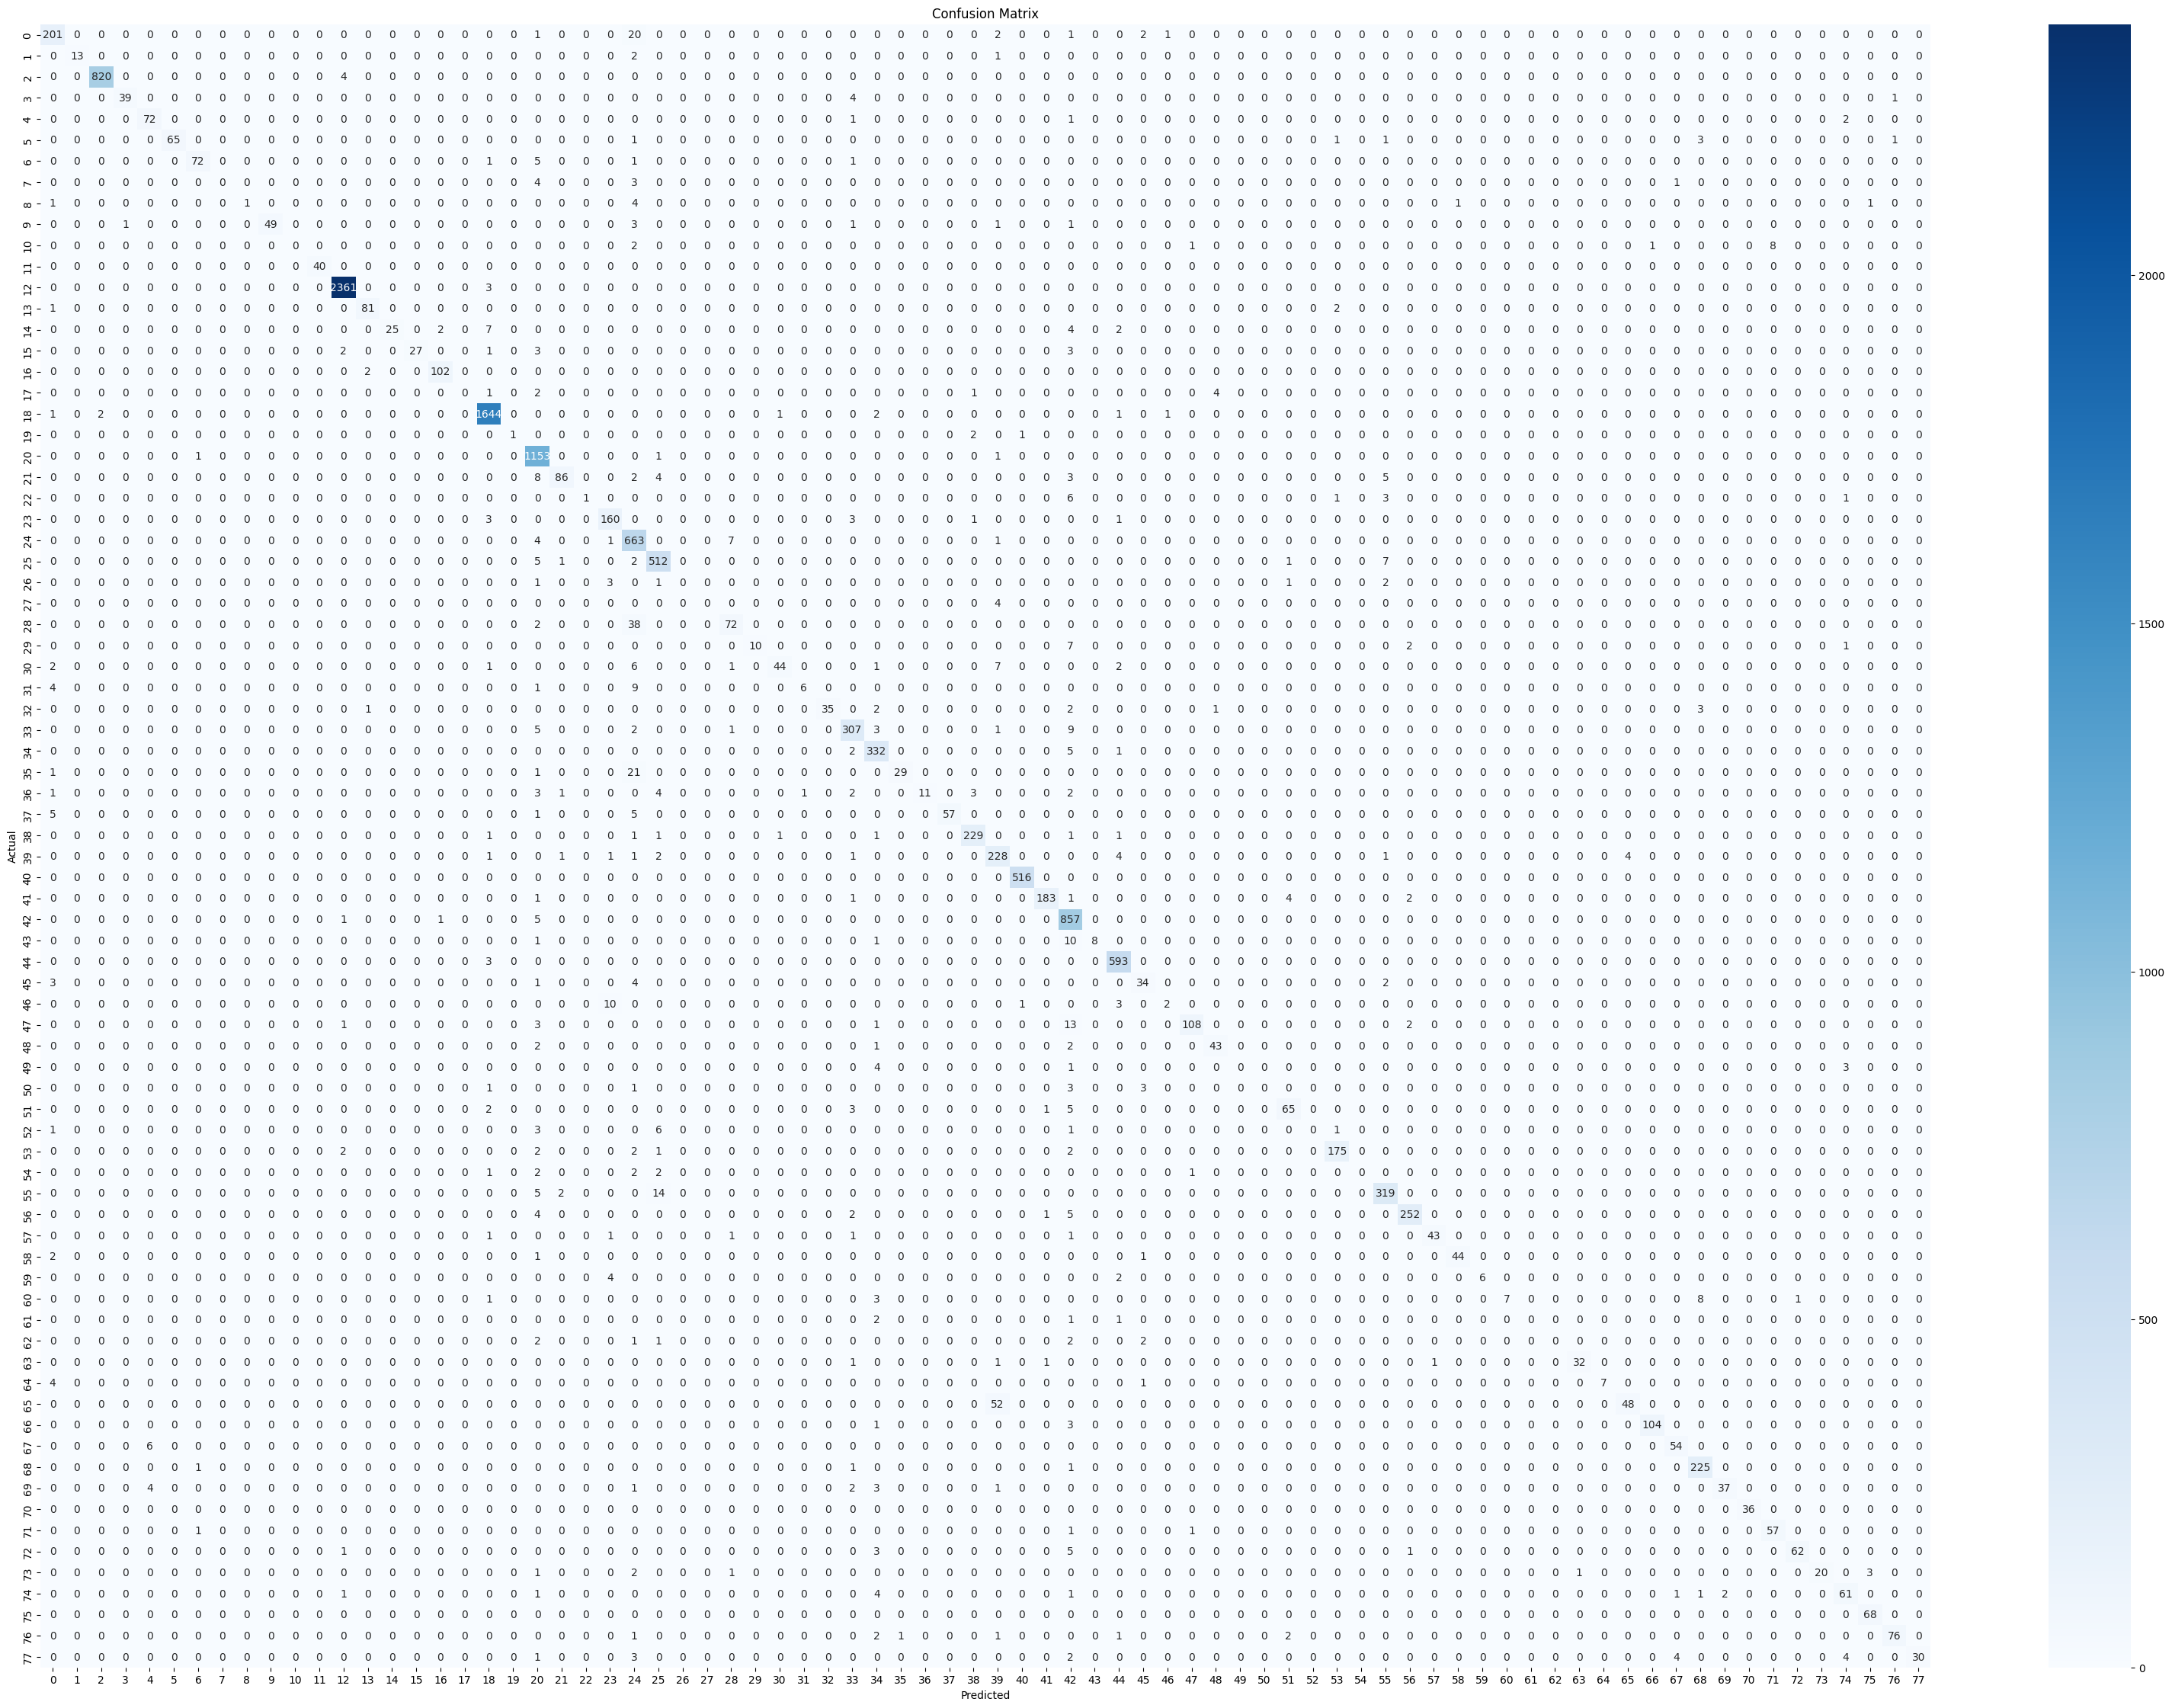

In [12]:
stats = ModelStatistics(save_name=f"svc_signer_test_{len(y_test_full)}", save_dir="signer/plots")
stats.print_accuracy(y_test_full, y_pred)
stats.plot_confusion_matrix(y_test_full, y_pred, save=True, plot=True, figsize=(40,28))